## Chapter 8. Gradient Descent

Frequently when doing data science, we’ll be trying to the find the best model for a certain situation. And usually “best” means **“minimizes the error of the model”** or **“maximizes the likelihood of the data.”** In other words, it will represent the solution to some sort of optimization problem.

This means we’ll need to solve a number of optimization problems. In particular,
we’ll need to solve them from scratch, + our approach = **gradient descent**, which lends itself pretty well to a from-scratch treatment.

### The Idea Behind Gradient Descent

Suppose we have some function `f` that takes as input a vector of real numbers and outputs a single real number. One simple such function is:

In [1]:
def sum_of_squares(vector):
    """Compute sum of squared elements in given vector"""
    return sum(element**2 for element in vector)

We’ll frequently need to maximize (or minimize) such functions, i.e. find the input `vector` that produces the largest (or smallest) possible value. For functions like ours, the **gradient** (vector of partial derivatives) gives the input a direction in which the function most quickly increases.

Accordingly, one approach to maximizing a function is to pick a random starting point,
compute the gradient, take a small step in the direction of the gradient (direction that causes the function to increase the most), and repeat with the new starting point.

Similarly, you can try to minimize a function by taking small steps in the opposite
direction (negative gradient)

* ***NOTE***: If a function has a unique **global minimum**, this procedure is likely to find it. If a function has **local (i.e. multiple) minima**, this procedure might “find” the wrong one of *them*, in which case you might re-run the procedure from a variety of starting points. **If a function has no minimum, then it’s possible the procedure might go on forever.**

## Estimating the Gradient

If `f` is a function of 1 variable, its **derivative** at a point `x` measures how f(x) changes when we make a very small change to x (**rate of change**). It is defined as the limit of the difference quotients:

In [2]:
def difference_quotient(f,x,h):
    return (f(x+h) - f(x)) / h

**Derivative = slope of the tangent line at `(x, f(x))`**, while the **difference quotient = slope of the not-quite-tangent line that runs through `(x+h, f(x+h))`**. As h gets smaller and smaller, the not-quite-tangent line gets closer and closer to the tangent line.For many functions it’s easy to exactly calculate derivatives. For example, the `square`
function's derivative:

In [3]:
def square(x):
    return x*x

def d_square(x):
    return 2*x

Can check, if so inclined, by explicitly computing the difference quotient and taking the limit.

What if you couldn’t (or didn’t want to) find the gradient? Although we can’t take limits in Python, we can *estimate derivatives by evaluating the difference quotient for a very small `e`*

In [4]:
## parital() = returns new partial object which when called behaves like
##   func called w/ the positional arguments `args` and keyword 
##   arguments `keywords`. 
## If more arguments are supplied, they are appended to args. 
## If additional keyword arguments are supplied, they extend + override 
##    keywords
from functools import partial

derivative_estimate = partial(difference_quotient, square, h = .00001)
#derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)

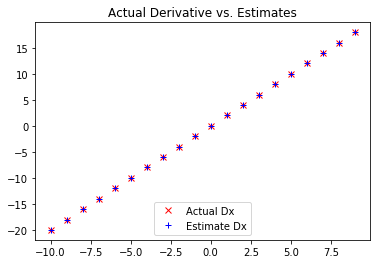

In [5]:
%matplotlib inline

# plot derivative + its estimate
import matplotlib.pyplot as plt

x = range(-10,10)
plt.title("Actual Derivative vs. Estimates")
# convert map result to list as matplotlib doesn't take generators as input
plt.plot(x, list(map(d_square, x)), 'rx', label="Actual Dx")
plt.plot(x, list(map(derivative_estimate, x)), 'b+', label="Estimate Dx")
plt.legend(loc=8)
plt.show()

When `f` is a function of many variables, it has *multiple* partial derivatives, each indicating how f changes when we make small changes w/ respect to just 1 of the input variables.
We calculate ith partial derivatives by treating them  as a function of just the ith variable, holding the other variables fixed:

In [7]:
def partial_difference_quotient(f,v,i,h):
    # add h to only the ith element of v
    w = [v_j + (h if j == i else 0)
        for j, v_j in enumerate(v)]
    
    return (f(x) - f(v)) / h

# estimate gradient in same manner
def estimate_gradient(f,v,h=.00001):
    return [partial_difference_quotient(f,v,i,h)
           for i, _ in enumerate(v)]

***NOTE***: Major drawback to this “estimate using difference quotients” approach = computationally expensive. If `v` has length `n`, `estimate_gradient` has to evaluate `f` on `2n` different inputs. If repeatedly estimating gradients, you’re doing a whole lot of extra work

### Using the Gradient

Easy to see that `sum_of_squares()` is smallest when input `v` = a vector of 0's. But imagine we didn’t know that. Let’s use gradients to find the minimum among all 3D vectors. Just pick a random starting point + then take tiny steps in the *opposite* direction of the gradient until we reach a point where the gradient is very small:

In [12]:
from math import sqrt
import random

def step(v,direction,step_size):
    """Move step_size units in `direction` from `v`"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v,direction)]

def sum_of_squares_gradient(v):
    return [2*v_i for v_i in v]

def dot(v,w):
    return sum(v_i*w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v):
    return dot(v,v)

def distance(v,w):
    return sqrt(sum_of_squares(v))

# pick random starting point
v = [random.randint(-10,10) for i in range(3)]

tolerance=.0000001

while True:
    # compute gradient @ v
    gradient = sum_of_squares_gradient(v)
    # take negative gradient step (towards min)
    next_v = step(v,gradient,-.01)
    # stop if converging, continue if not
    if distance(next_v,v) < tolerance:
        break
    v = next_v
    
print(v)

[0.0, 2.9277120618321604e-08, -9.759040206107214e-08]


This will always ends up with a `v` very close to [0,0,0]. The smaller the `tolerance`, the closer it will get

### Choosing the Right Step Size

Although the rationale for moving against the gradient is clear, how far to move is not. Choosing correct step size = more of an art than a science. Popular options include:

* Using a fixed step size
* Gradually shrinking step size over time
* At each step, choosing step size that minimizes the value of the **objective function** (sounds optimal but is, in practice, a costly computation). 

We can approximate it the 3rd option by trying a variety of step sizes + choosing the one that results in the smallest value of the objective function. 

It is possible that certain step sizes will result in invalid inputs for our function, so we’ll create a `“safe apply”` function that returns infinity (which should never be the minimum of anything) for invalid inputs.

In [13]:
step_sizes = [100,10,1,.1,.01,.001,.0001,.00001]

def safe(f):
    """Return a new function that's the same as f except
    it outputs Infinity whenever f produces an error"""
    def safe_f(*args,**kwargs):
        try:
            return f(*args,**kwargs)
        except:
            return float('inf') # = infinity in Python
    return safe_f

### Putting It All Together

In the general case, we have some `target_fn` we want to minimize, and we also have its `gradient_fn`. For example, `target_fn` could represent the errors in a model as a function of its parameters, + we might want to find the parameters that make the errors as small as possible.

Furthermore, let’s say we have (somehow) chosen a starting value for the parameters `theta_0`. Then we can implement gradient descent as:

In [14]:
def minimize_batch(target_f,gradient_f,theta0,tolerance=.00001):
    """Use gradient descent to find theta that minimizes target function"""
    step_sizes = [100,10,1,.1,.01,.001,.0001,.00001]
    
    theta=theta0                    # set theta to initial value
    target_f = safe(target_f)       # safe version of target function
    value = target_f(theta)         # value to minimize
    
    while True:
        gradient=gradient_f(theta)
        next_thetas = [step(theta,gradient,-step_size)
                      for step_size in step_sizes]
        # choose theta that minimizes error function
        next_theta = min(next_theta, keys=target_f)
        next_value = target_f(next_theta)
        # stop if converging
        if abs(value-next_value) < tolerance:
            return theta
        else:
            theta,value = next_theta,next_value

We called it `minimize_batch` b/c, for each gradient step, it looks at the entire data set (b/c `target_fn` returns the error on the *whole* data set). Later, we’ll see an alternative approach that only looks at 1 DP at a time.

Sometimes we’ll instead want to maximize a function, which we can do by minimizing its negative (which has a corresponding negative gradient):

In [15]:
def negate(f):
    """Return a function that, for any input, x, returns -f(x)"""
    return lambda *args,**kwargs: -f(*args,**kwargs)

def negate_all(f):
    """Same as above but for when f returns a list of numbers"""
    return lambda *args,**kwargs: [-y for y in f(*args,**kwargs)]

def maximize_batch(target_f,gradient_f,theta0,tolerance=.00001):
    return minimize_batch(negate(target_f),
                         negate_all(gradient_f),
                         theta0,
                         tolerance)

### Stochastic Gradient Descent

Often we’ll be using gradient descent to choose the parameters of a model in a way that minimizes some notion of error. Using the previous batch approach, each gradient step requires us to make a prediction and compute the gradient for the *whole data set*, which makes each step take a long time.

Usually these error functions are **additive** = the predictive error on
the whole data set is simply the sum of the predictive errors for each DP. When this is the case, we can instead apply **stochastic gradient descent** = computes the gradient (+ takes a step) for only *one* point at a time. It cycles over data repeatedly until it reaches a stopping point. During each cycle, we’ll want to iterate through our data in a random order:

In [16]:
def in_random_order(data):
    """Generator that returns elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)] # create list of indexes
    random.shuffle(indexes)                   # shuffle indices
    for i in indexes:                         # return data in that order
        yield data[i] #????????

Want to take a gradient step for each DP, + this approach leaves the possibility that we might circle around near a minimum forever, so whenever we stop getting improvements we’ll decrease the step size and eventually quit:

In [18]:
def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def minimize_stochastic(target_f,gradient_f,x,y,theta0,alpha0=.01):
    data = zip(x,y)
    theta=theta0                     # initial guess
    alpha=alpha0                     # initial step size
    min_theta,min_value = None, float("inf")
    iterations_with_no_improvement = 0
    
    # If we get to 100 iterations w/ no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_f(x_i,y_i,theta) for x_i,y_i in data)
        
        if value < min_value:
            # if a new min is found, remember it and 
            # go back to original step size
            min_theta,min_value = theta,value
            iterations_with_no_improvement=0
            alpha=alpha0
        else:
            # otherwise, no improvement found, so try shrinking step size
            iterations_with_no_improvement += 1
            alpha *= .9
        
        # take gradient step for each data point
        for x_i,y_i in in_random_order(data):
            gradient_i = gradient_f(x_i,y_i,theta)
            theta=vector_subtract(theta,scalar_multiply(alpha,gradient_i))
            
    return min_theta

The stochastic version will typically be a lot faster than the batch version. Of course, we’ll want a version that maximizes as well

In [19]:
def maximize_stochastic(target_f,gradient_f,x,y,theta0,alpha0=.01):
    return minimize_stochastic(negate(target_f),
                              negate_all(gradient_f),
                              x,y,theta0,alpha0)